<h1>Extended Lens Functionality</h1>

The below code uses the analysis methodology of https://arxiv.org/abs/2002.08962 to compute the magnification curve associated with an extended lens given by some mass profile $\rho(r)$ with compactness specified by $r_{90}$, the radius in which $90\%$ of the mass is enclosed.

To do this, it solves the lensing equation $\beta = \theta - \frac{\theta_E^2}{\theta}\frac{M(\theta)}{M}$. This equation is in terms of angles, however it can be recast in a dimensionless form for transverse radial distances in the plane of the lens. These coordinates are $u$, the impact parameter measured in $r_E$ in the plane of the lens, and $v$, the image location in units of $r_E$ in the plane of the lens. The equation then becomes $u = v - \frac{1}{v}\frac{M(v)}{M_{tot}}$ where any overall normalization of the mass function cancels in the ratio.

Given an impact parameter $u$, this equation can be solved numerically to yield a corresponding image location $v$. The magnification is then given by $A = |\frac{\theta}{\beta}\frac{d\theta}{d\beta}| = |\frac{v}{u}\frac{dv}{du}|$. Hence, having solved for $v$ as a function of $u$, one can compute the curve $A(u)$.

There is a nuance in this analysis, however, which is that often $v(u)$ is not a single-valued function. Multiple images can be produced, hence the $v(u)$ curve must be split along its branches and the magnification must be computed for each image, then each of these magnifications summed to yield the total magnification.

In [3]:
# Import necessary packages

import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt

We use an NFW profile as a test case.

$\rho(r, \rho_s, r_s) = \frac{\rho_s}{(r/r_s)(1+(r/r_s))^2}$

In [4]:
# Define the density profile of the extended lens, here an NFW profile with truncation radius 100 rs.
# Note that r90 = 69*rs for an NFW profile.

def rho(r, r90):
    rs = r90/69
    if 0 < r < 100*rs:
        return(((r/rs)*(1 + (r/rs))**2)**-1)
    elif r >= 100*rs:
        return(0)
    else:
        print("ERROR: r/r90 are not a valid non-negative float.")

The following functions compute the projected mass between two radial locations in the plane of the lens $v_a$ and $v_b$. This allows us to perform a much faster integral by saving the integration value for a previous $v$ and simply adding on the next interval.

In [611]:
def M(va, vb, r90):
    f = lambda vp, z: vp * rho(np.sqrt(vp**2 + z**2), r90)
    integral = integrate.dblquad(f, -np.inf, np.inf, va, vb)
    return(integral[0])

In [618]:
def M(va, vb, r90):
    f = lambda vp, z: vp * rho(np.sqrt(vp**2 + z**2), r90)
    rmax = (100/69)*r90
    integral = integrate.dblquad(f, -rmax, rmax, va, vb)
    return(integral[0])

The function "Ms" returns a tuple of the $v$-values used in the analysis (between $v_\text{min}$ and $v_\text{max}$) and their corresponding $M(v)$.

In [634]:
def Ms(r90, vmin, vmax, vincrement):
    
    output = np.array([])
    vs = np.arange(vmin, vmax, vincrement)
    running_int = M(0, vmin, r90)
    for i in np.arange(len(vs)-1):
        this_int = M(vs[i], vs[i+1], r90)
        running_int += this_int
        output = np.append(output, running_int)
        
    return((vs+vincrement)[0:-1], output)

Since we don't care about the actual masses, we work in ratios with respect to the total mass.

In [632]:
def Mratios(r90, vmin, vmax, vincrement):
    tab = Ms(r90, vmin, vmax, vincrement)
    rmax = (100/69)*r90
    Mtot = M(0, rmax, r90)
    return(r90, tab[0], tab[1]/Mtot)

Here, we calculate $u$ as a function of $v$. Note that the mass-ratios also have a $v$-dependence.

In [8]:
def u(r90, vs, Mrats):
    return(vs - vs**-1 * Mrats)

This code checks for places in which the slope of the $u(v)$ curve flips, implying $v(u)$ is multi-valued. It then splits a given set of $u, v$ pairs into various curves corresponding to the different branches.

In [118]:
def signChanges(us):
    # Things are safe up to this element of the array
    usign = np.diff(np.sign(np.diff(us)))
    flipidxs = np.nonzero(usign)[0]+1
    
    return(np.append(0,np.append(flipidxs, -1)))

In [117]:
signChanges(us)

array([ 0,  8, -1])

In [119]:
def splitCurves(us, vs):
    signchanges = signChanges(us)
    
    curves = []
    for i in range(len(signchanges)-1):
        ucurve = np.array(us[signchanges[i]:signchanges[i+1]])
        vcurve = np.array(vs[signchanges[i]:signchanges[i+1]])
        
        curves.append(np.array([ucurve, vcurve]))
                       
    return(curves)
        

centerdiff is a helper function for the numerical derivative we will perform to get the magnification curve.

In [120]:
def centerdiff(array):
    return([array[i+1]-array[i-1] for i in range(1, len(array)-2)])

This function performs a numerical derivative to calculate the value of the magnification for each $u, v$ pair, then returns a tuple of the corresponding $u$-values and $A$-values that allows one to construct $A_i(u)$ for each branch of solutions $i$.

In [121]:
def magnificationCurve(us, vs):
    return(us[1:-2], np.abs((vs[1:-2]*centerdiff(vs))/(us[1:-2]*centerdiff(us))))

Here, we compute the magnification curve for each branch of the solution at the $u$-values given by umags by interpolating each curve to these values. We also include the branches corresponding to $u, v \rightarrow -u, -v$. We then sum all of the results. This yields $A_\text{tot}$.

In [340]:
def totalMagnificationCurve(curves, umax, ustep):
    
    # This must be a symmetric range in order to compute negative contribution correctly.
    umags = np.append(-np.flip(np.arange(ustep, umax, ustep)), np.arange(ustep, umax, ustep))
    
    Amags = np.zeros([len(umags)])
    
    for curve in curves:
        us = curve[0]
        vs = curve[1]
        
        u1s, A1s = magnificationCurve(us, vs)
        
        Amags += np.interp(umags, u1s, A1s)
        if np.max(umags) > np.max(u1s) or np.min(np.abs(umags)) < np.min(u1s):
            print("Leaving range of safe interpolation.")
        Amags[umags > np.max(u1s)] = 0
        Amags[umags < np.min(u1s)] = 0
        
    # We must also account for the negative image branch.
    Amagstotal = Amags + np.flip(Amags)
        
    return(umags, Amagstotal)
        
        

This finds the first time the magnification drops below some threshold, hence yields $u_T$.

In [160]:
def find_uT(Athresh, umags, Amags):
    if np.max(Amags) < Athresh:
        print("A always < Athresh.")
        return(0)
    elif np.min(Amags) > Athresh:
        print("A always > Athresh.")
        return(np.inf)
    elif Amags[0] > Athresh:
        uT = umags[np.argmax(Amags < Athresh)]
    elif Amags[0] < Athresh:
        uT = umags[np.argmax(Amags > Athresh)]
    else:
        print("Error in uT computation.")
    
    return(uT)

Finally, we can capture this as a single function if we want to just compute A(u) on the fly.

In [663]:
def GenerateMagnificationCurve(r90, vmin=0.001, vmax=5, vstep=0.005, umax=4, ustep=0.01, AT=1.34):
    r90, vs, Mrats = Mratios(r90, vmin, vmax, vstep)
    us = u(r90, vs, Mrats)
    curves = splitCurves(us, vs)
    print("There is/are "+str(len(curves))+" positive branch(es).")
    
    umags, Amags = totalMagnificationCurve(curves, umax, ustep)
    uT = find_uT(AT, umags, Amags)
    
    print("u_T = "+str(np.abs(uT)))
    
    return(umags, Amags)

<h2>Example usage</h2>

A basic example.

In [699]:
umags, Amags = GenerateMagnificationCurve(20)

There is/are 2 positive branch(es).
Leaving range of safe interpolation.
u_T = 0.6


/usr/local/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


In [703]:
np.save("r90=20.npy", np.array([umags, Amags]))

A case that requires finer resolution.

In [705]:
umags, Amags = GenerateMagnificationCurve(1,vstep=0.0001)

/usr/local/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:879: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


There is/are 2 positive branch(es).
Leaving range of safe interpolation.
u_T = 1.0


In [706]:
np.save("r90=1.npy", np.array([umags, Amags]))

A case near point-like.

In [707]:
umags, Amags = GenerateMagnificationCurve(0.1)

There is/are 1 positive branch(es).
u_T = 1.0


In [708]:
np.save("r90=0.1.npy", np.array([umags, Amags]))

A case near point-like with a different threshold magnification.

In [666]:
umags, Amags = GenerateMagnificationCurve(0.1, AT=1.1)

There is/are 1 positive branch(es).
u_T = 1.6700000000000002


An extreme example in which finer resolution and minimum step is required

In [668]:
umags, Amags = GenerateMagnificationCurve(0.001, vmin=0.0001, vstep=0.0005)

There is/are 1 positive branch(es).
u_T = 1.0


An extreme example of large $r_{90}$.

In [698]:
umags, Amags = GenerateMagnificationCurve(90)

There is/are 1 positive branch(es).
u_T = 0.15000000000000002


/usr/local/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:879: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


In [709]:
umags, Amags = GenerateMagnificationCurve(100)

There is/are 1 positive branch(es).
u_T = 0.11


In [710]:
np.save("r90=100.npy", np.array([umags, Amags]))

In [711]:
umags, Amags = GenerateMagnificationCurve(5,vstep=0.0001)

There is/are 2 positive branch(es).
Leaving range of safe interpolation.
u_T = 1.09


In [712]:
np.save("r90=5.npy", np.array([umags, Amags]))

In [714]:
umags, Amags = GenerateMagnificationCurve(10)

There is/are 2 positive branch(es).
Leaving range of safe interpolation.
u_T = 0.68


In [715]:
np.save("r90=10.npy", np.array([umags, Amags]))

In [716]:
umags, Amags = GenerateMagnificationCurve(50)

There is/are 1 positive branch(es).
u_T = 0.39


In [717]:
np.save("r90=50.npy", np.array([umags, Amags]))

<h2>Examples (broken down by step)</h2>

<h3>$r_{90} = 20 r_E$ NFW</h3>

Here is the case for an NFW profile with $r_{90} = 20 r_E$.

In [230]:
r90, vs, Mrats = Mratios(20, 0.001, 3, 0.001)

In [231]:
us = u(r90, vs, Mrats)

In [232]:
curves = splitCurves(us, vs)

We see the two branches in the $v(u)$ plot. They have been split and colored blue and orange.

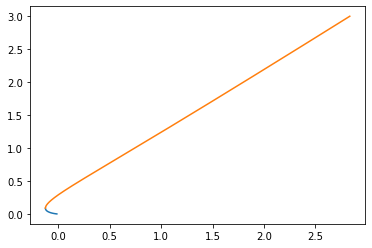

In [233]:
plt.plot(curves[0][0], curves[0][1])
plt.plot(curves[1][0], curves[1][1])

In [234]:
umags, Amags = totalMagnificationCurve(curves, 3, 0.01)

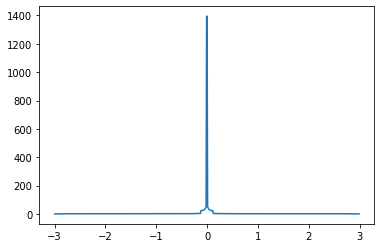

In [235]:
plt.plot(umags, Amags)

In [236]:
find_uT(1.34, umags, Amags)

-0.610000000000051

This agrees with the curve in Djuna's paper.

<h3>$r_{90} = 0.1 r_E$ NFW (i.e. point source)</h3>

In [352]:
r90, vs, Mrats = Mratios(0.1, 0.001, 5, 0.01)

In [345]:
us = u(r90, vs, Mrats)

In [346]:
curves = splitCurves(us, vs)

Here, there is only one branch in the $v(u)$ plot.

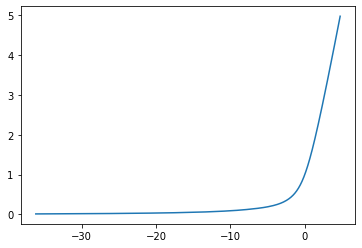

In [347]:
plt.plot(curves[0][0][0:8000], curves[0][1][0:8000])

In [348]:
umags, Amags = totalMagnificationCurve(curves, 4, 0.01)

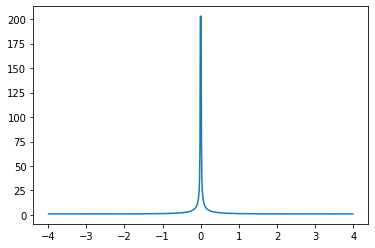

In [349]:
plt.plot(umags, Amags)

In [350]:
find_uT(1.34, umags, Amags)

-0.99

<h3>$r_{90} = 1 r_E$ NFW (singular)</h3>

This region requires finer resolution to capture both branches.

In [689]:
r90, vs, Mrats = Mratios(1, 0.0001, 5, 0.0001)

In [690]:
us = u(r90, vs, Mrats)

In [691]:
curves = splitCurves(us, vs)

Here, there are two branches in the $v(u)$ plot.

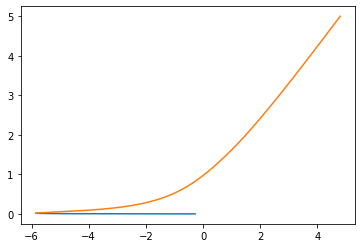

In [692]:
plt.plot(curves[0][0], curves[0][1])
plt.plot(curves[1][0], curves[1][1])

In [693]:
umags, Amags = totalMagnificationCurve(curves, 10, 0.01)

Leaving range of safe interpolation.
Leaving range of safe interpolation.


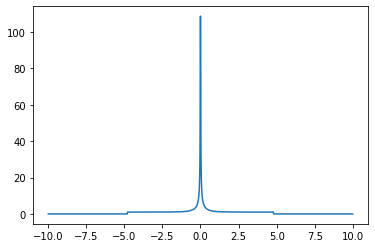

In [694]:
plt.plot(umags, Amags)

In [695]:
find_uT(1.34, umags, Amags)

-1.0

As expected, $u_T \rightarrow 1$ for $A_T \rightarrow 1.34$ in this limit.

<h3>$r_{90} = 0.001 r_E$ NFW (i.e. point source)</h3>

In [656]:
r90, vs, Mrats = Mratios(0.001, 0.0001, 5, 0.0001)

In [657]:
us = u(r90, vs, Mrats)

In [658]:
curves = splitCurves(us, vs)

Here, there is only one branch in the $v(u)$ plot.

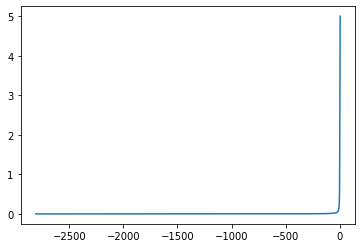

In [659]:
plt.plot(curves[0][0], curves[0][1])

In [660]:
umags, Amags = totalMagnificationCurve(curves, 4, 0.01)

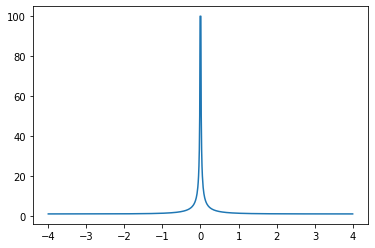

In [661]:
plt.plot(umags, Amags)

In [662]:
find_uT(1.34, umags, Amags)

-1.0

As expected, $u_T \rightarrow 1$ for $A_T \rightarrow 1.34$ in this limit.

<h3>$r_{90} = 90 r_E$ NFW (extreme case)</h3>

Here is the extreme case of $r_{90} = 90 r_E$.

In [328]:
r90, vs, Mrats = Mratios(90, 0.00001, 4, 0.001)

/usr/local/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


In [329]:
us = u(r90, vs, Mrats)

In [330]:
curves = splitCurves(us, vs)

In [331]:
len(curves)

1

Here, there is only one branch in the $v(u)$ plot.

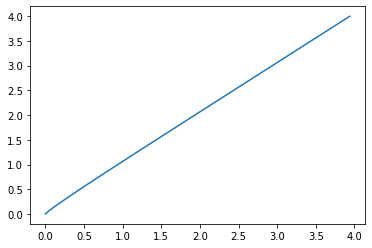

In [332]:
plt.plot(curves[0][0],curves[0][1])

In [333]:
umags, Amags = totalMagnificationCurve(curves, 3, 0.01)

The inverted feature is due to the fact that these values of $u$ are so small that they lie outside our range of interpolation, hence are artificially set to zero. They ultimately do not affect the result, but maybe should be fixed.

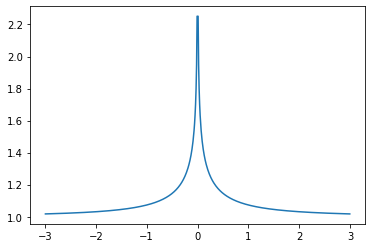

In [334]:
plt.plot(umags, Amags)

In [335]:
find_uT(1.34, umags, Amags)

-0.15000000000000002